In [1]:
#Date: 21/03/2021
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

# Loading all the libraries

%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain
from nilearn import signal
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML


C:\ProgramData\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Data directory

# Path to data in my PC
path = 'C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\WHMSTS**\\*.txt'

# List of all the text files
sub_list = [x for x in glob.iglob(path, recursive=True)]

# Initiating empty list for all time points
time_p = []

########################################################################################################################################

# Iterating over ROIs of each subject
for sub in sub_list:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a,b) =  activation_values.shape
    time_p.append(a)

# Selecting the lowest value
time_dim = min(time_p)

print ('The minimum number of time points =', time_dim)

########################################################################################################################################

The minimum number of time points = 206


In [3]:
# Processing data to remove all ROIs having zero value for BOLD activation

# Initiating timeseries data as list
timeseries_3D = []

# All indices having zero value
zeroes = []

# Iterating over ROIs of each subject
for sub in sub_list:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis = 0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)
    
    zeroes.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D.append(activation_values[0:time_dim, :])

# Converting timeseries data in numpy array
timeseries_3D = np.asarray(timeseries_3D)

# Unique zero values for all ROIs
zeroes = np.unique(zeroes).astype(int)

# Removing ROIs having zeroes
timeseries_3D = np.delete(timeseries_3D, zeroes, axis=2)

# Dimension check for the output
print ('Dimensions (Subjects, Timepoints, ROIs) =', timeseries_3D.shape)

Dimensions (Subjects, Timepoints, ROIs) = (64, 206, 268)


In [4]:
# Converting the numpy data to panda dataframe

# Initiating timeseries as dictionary for all records
timeseries = {}

# Converting numpy data into panda dataframe for each participant
for sub in range(timeseries_3D.shape[0]):
    timeseries[sub] = pd.DataFrame(timeseries_3D[sub, :, :])

In [5]:
# Standardising the timeseries by z-transforming

# Initialising standard timeseries dictionary
z_timeseries = {}

# Using z-score to standardise each value
for sub in range(timeseries_3D.shape[0]):
  z_timeseries[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  z_timeseries[sub] = pd.DataFrame(z_timeseries[sub])

print ('Dimensions of each subject =', z_timeseries[sub].shape)
print ('No. of subjects =', len(z_timeseries))

Dimensions of each subject = (206, 268)
No. of subjects = 64


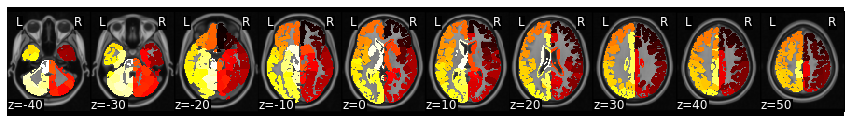

In [6]:
# Mask with 268 parcellations

# Importing mask from Neurovault
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

In [7]:
# Selecting ROI for ISC analysis

def get_subject_roi(data = dict, roi = int):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

# Testing for region 78
roi = 78
roi_roi = get_subject_roi(z_timeseries, roi)
print('Dimensions of data for ROI', roi,'=', roi_roi.shape)

Dimensions of data for ROI 78 = (206, 64)


In [8]:
# Testing - ISC for ROI = 78, and no. of bootstraps = 10000

stats = isc(get_subject_roi(z_timeseries, 78), n_bootstraps=10000, metric='median', method='bootstrap')
print(f"ISC: {stats['isc']:.02}, p = {stats['p']:.03}")

ISC: 0.14, p = 0.0001


In [9]:
# Testing - ISC for ROI = 78, and no. of bootstraps = 500000 (Effects of more no. of bootstraps)

stats = isc(get_subject_roi(z_timeseries, 78), n_bootstraps=500000, metric='median', method='bootstrap')
print(f"ISC: {stats['isc']:.02}, p = {stats['p']:.03}")

ISC: 0.14, p = 2e-06


In [10]:
# Running ISC on all ROIs

# Intialising isc and p-value dictionaries
isc_r, isc_p = {}, {}

# Iterating over each ROI
for roi in range(268):
    stats = isc(get_subject_roi(z_timeseries, roi), n_bootstraps=10000, metric='median', method='bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']

# Converting correlation and p-value back into a Brain_Data instance
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


In [11]:
# Sorting the parcels by their value of correlation (positive to negative)

# Ascending sorting of the correlation values
isc_rr = sorted(isc_r.items(), key=lambda x:x[1])

# Initiating empty list for sorted ISC values
isc_sorted = []

# Iterating over all the tuples in isc_rr
for i in range(len(isc_rr)):
    (a,b) = isc_rr[i]
    isc_sorted.append(a)

# Reverse sorting
isc_sorted = isc_sorted[::-1]

# isc_pp = sorted(isc_p.items(), key=lambda x:x[1])

print ('Parcels from positive to negative correlation =', isc_sorted)

Parcels from positive to negative correlation = [208, 73, 79, 205, 214, 203, 72, 207, 78, 209, 206, 199, 210, 65, 66, 211, 74, 75, 68, 40, 49, 71, 212, 178, 174, 43, 177, 143, 76, 77, 48, 37, 42, 81, 182, 141, 80, 41, 181, 149, 70, 215, 202, 64, 165, 145, 204, 213, 191, 175, 218, 89, 183, 176, 197, 47, 44, 170, 224, 160, 147, 162, 161, 200, 85, 82, 27, 222, 25, 84, 180, 148, 198, 24, 144, 196, 87, 137, 229, 217, 5, 139, 51, 14, 190, 97, 223, 23, 185, 153, 90, 221, 4, 150, 46, 168, 192, 152, 8, 140, 159, 166, 167, 186, 31, 88, 173, 86, 220, 9, 189, 156, 169, 255, 6, 10, 67, 155, 142, 225, 52, 38, 45, 240, 30, 241, 62, 164, 231, 50, 11, 163, 154, 133, 56, 32, 172, 184, 179, 28, 69, 230, 245, 138, 262, 55, 239, 216, 0, 234, 249, 20, 53, 246, 58, 110, 259, 226, 252, 187, 146, 106, 157, 99, 96, 171, 237, 63, 260, 115, 127, 244, 83, 151, 2, 59, 247, 91, 54, 195, 158, 258, 101, 232, 134, 136, 22, 253, 108, 12, 60, 227, 248, 16, 21, 120, 57, 26, 29, 7, 3, 104, 35, 121, 235, 13, 267, 251, 113, 

In [12]:
# Visualisation of regions of high correlation

# print ('Degree of correlation in Parcels')
# isc_r_brain.plot(cmap='RdBu_r')

# print ('Significance of correlation in Parcels')
# isc_p_brain.plot(cmap='RdBu_r')

Visualising Correlation


C:\ProgramData\Anaconda3\lib\site-packages\nilearn\plotting\html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



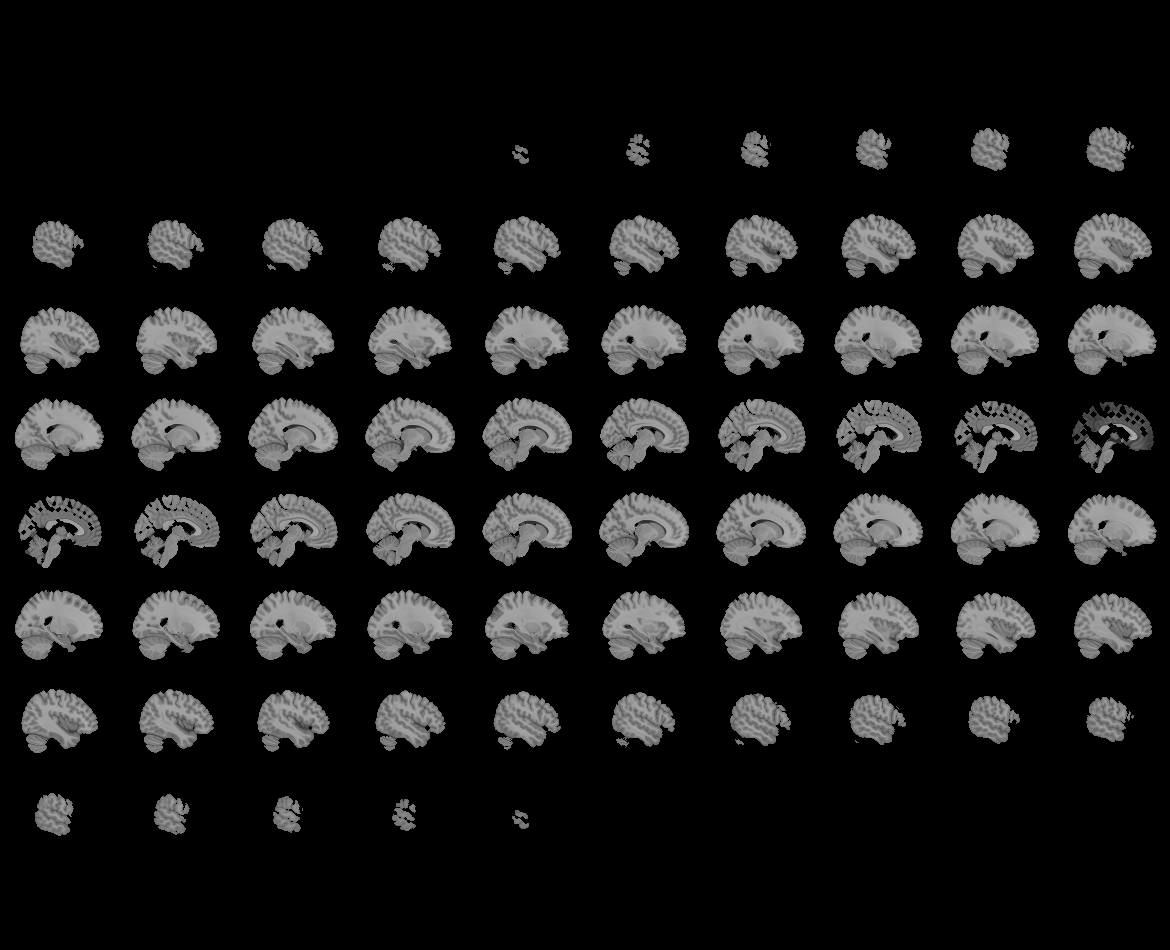
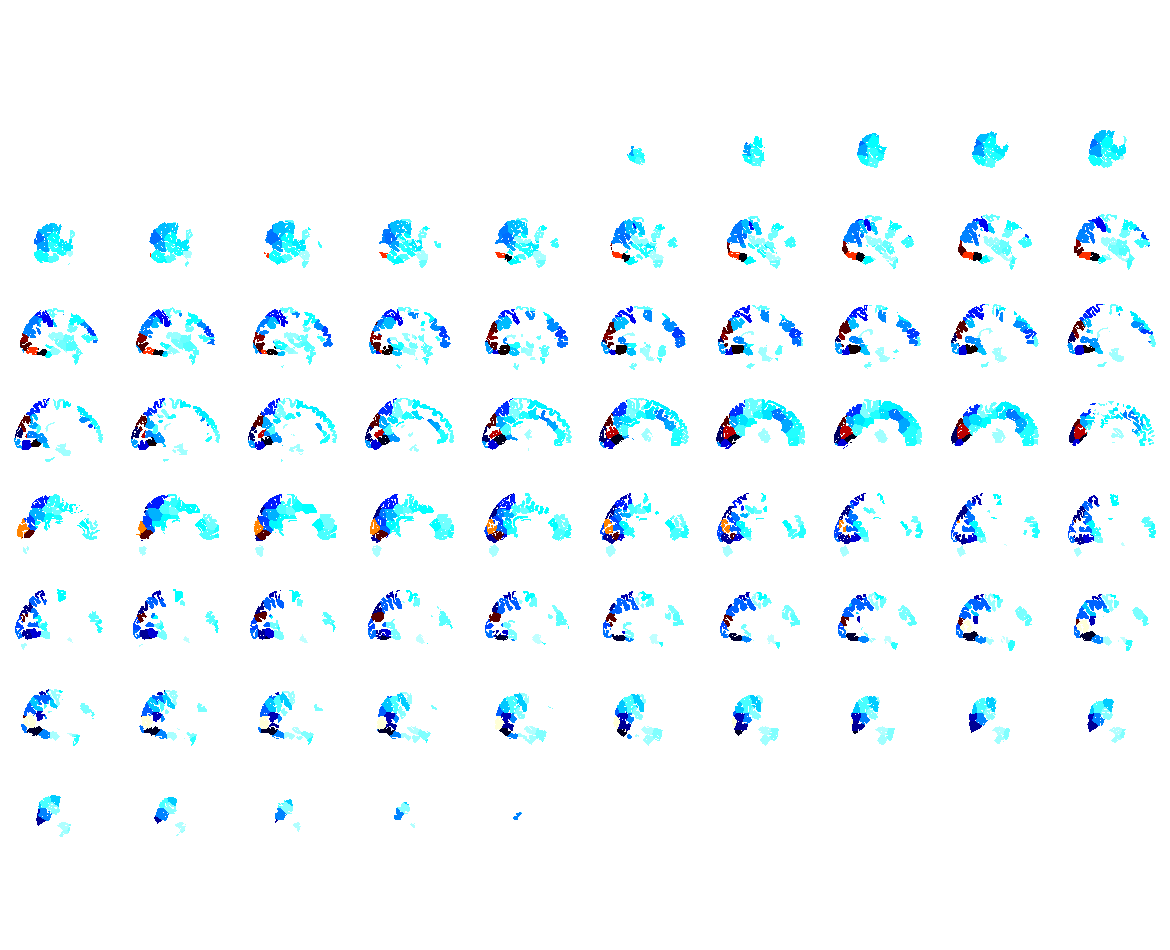

In [13]:
# Mapping correlation

print ('Visualising Correlation')
view_img(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti(), symmetric_cmap=False)


In [14]:
view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti())


Correlations


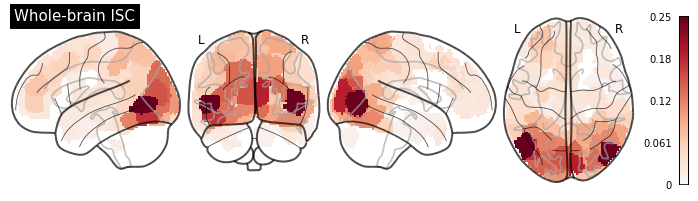

In [15]:
# Projection of correlation values on the brain glass

print ('Correlations')
plot_glass_brain(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='Whole-brain ISC')


In [16]:
new_file = 'C:\\Users\\theab\\OneDrive\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\WHMSTS_isc.nii.gz'

threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).write(new_file)